In [25]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from torch.distributions import MultivariateNormal
import matplotlib

plt.close('all')

plt.rc('font', size=14)          # controls default text sizes
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [26]:
class score_nn(torch.nn.Module):
    def __init__(self, x_dim, hidden_dim):
        super(score_nn, self).__init__()
        self.x_dim = x_dim
        self.hidden_dim = hidden_dim
        
        self.activation = nn.ELU()
        
        self.layer_input = nn.Linear(self.x_dim + 1, self.hidden_dim, bias=True)
        self.layer_1 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layer_2 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)

        self.layer_3 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layer_4 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)

        self.layer_out = nn.Linear(self.hidden_dim, x_dim-1, bias=True)
                
    def forward(self, x,t):
        z_in = torch.concat((x,t),dim=2)
        h = self.layer_input(z_in)
        h_temp = self.activation(self.layer_1(h)) 
        h_temp = self.activation(self.layer_2(h_temp)) 
        h = h_temp + h 

        # h_temp = self.activation(self.layer_3(h)) 
        # h_temp = self.activation(self.layer_4(h_temp)) 
        # h = h_temp + h 

        z_out = self.layer_out(h) 
        return z_out

In [27]:
N = 2000 # number of samples
T = 100  # number of time steps
n = 2 # system dimension
m = 1 # control dimension

tf = 1.0 # time horizon
dt = tf/T # time step

n_sigma = 1 # noise level


w = 0.5 # frequency

A = torch.tensor([[0.0, w],[-w, 0.0]])
B = torch.tensor([[0.0],[1.0]])

In [28]:
x_0 = MultivariateNormal(torch.zeros(n), torch.eye(n)).sample((N,))

mu_target = torch.tensor([3.0,3.0])*2

y = torch.zeros((N,n))
y[:int(N/2)] = MultivariateNormal(mu_target, torch.eye(n)).sample((int(N/2),))
y[int(N/2):] = MultivariateNormal(-mu_target, torch.eye(n)).sample((N//2,))

In [29]:
X_f = torch.zeros((T, N, n))
W_f = torch.zeros((T, N, m))


X_f[0] = x_0

t_N = torch.linspace(0.0, tf, T).repeat(N,1).reshape(N,T,1).permute(1,0,2) # shape (T,N,1)

In [30]:
def generate_phit(t, n, w):
    """
    t shape is (T, N, 1), output shape is (T, N, n, n)
    """
    T, N, _ = t.shape
    phi_t = torch.zeros((T, N, n, n))
    phi_t[:,:,0,0] = t[:,:,0]/2 - torch.sin(2*w*t[:,:,0])/(4*w)
    phi_t[:,:,0,1] = torch.sin(w*t[:,:,0])**2/(2*w)
    phi_t[:,:,1,0] = torch.sin(w*t[:,:,0])**2/(2*w)
    phi_t[:,:,1,1] = t[:,:,0]/2 + torch.sin(2*w*t[:,:,0])/(4*w)
    return phi_t

In [31]:
def generate_expAt(A, t):
    """
    A shape is (n,n), t shape is (T,N,1), output shape is (T,N,n,n)
    """
    T, N, _ = t.shape
    A_rep = A.repeat(T,N,1,1)
    A_t = A_rep * t.unsqueeze(-1)
    A_t_exp = torch.matrix_exp(A_t)

    return A_t_exp

In [32]:
expAt = generate_expAt(A, t_N)
exp1tAtrans = generate_expAt(A.T, 1-t_N)
expA = generate_expAt(A, torch.ones_like(t_N))
exp1tA = generate_expAt(A, 1-t_N)
phi_t = generate_phit(t_N, n, w)
phi_1 = generate_phit(torch.ones_like(t_N), n, w)
phi_1_t = generate_phit(1-t_N, n, w)

mat_for_x = expAt - torch.einsum('tnij,tnjk->tnik', torch.einsum('tnij,tnjk->tnik', torch.einsum('tnij,tnjk->tnik', phi_t, exp1tAtrans), torch.linalg.inv(phi_1)), expA)

mat_for_y = torch.einsum('tnij,tnjk->tnik', torch.einsum('tnij,tnjk->tnik', phi_t, exp1tAtrans), torch.linalg.pinv(phi_1))

phi_t_exp1tAtrans = torch.einsum('tnij,tnjk->tnik', phi_t, exp1tAtrans)
Sigma_t = phi_t - torch.einsum('tnij,tnjk->tnik', torch.einsum('tnij,tnjk->tnik', phi_t_exp1tAtrans, torch.linalg.pinv(phi_1)), phi_t_exp1tAtrans.transpose(-1,-2))

Z_f = torch.zeros((T, N, n))
for i in range(T):
    if i != 0 and i != T-1 and i != T-2:
        # print(i)
        Z_f[i,:,:] = MultivariateNormal(torch.zeros(n), Sigma_t[i,0,:,:]).sample((N,))

In [33]:
X_f = torch.einsum('tnij,tnj->tni', mat_for_x, x_0.unsqueeze(0).repeat(T,1,1)) + torch.einsum('tnij,tnj->tni', mat_for_y, y.unsqueeze(0).repeat(T,1,1)) + n_sigma * Z_f

In [34]:
u_f = torch.einsum('tnij,tnj->tni',torch.einsum('tnij,tnjk->tnik', torch.einsum('ij,tnjk->tnik', B.T, exp1tAtrans), torch.linalg.pinv(phi_1_t)), y[None,:,:] - torch.einsum('tnij, tnj->tni', exp1tA, X_f))

In [35]:
print(X_f[-1,:,:].mean(dim = 0))
print(X_f[-1,:,:].std(dim = 0))

tensor([-0.0009, -0.0091])
tensor([6.0629, 6.1051])


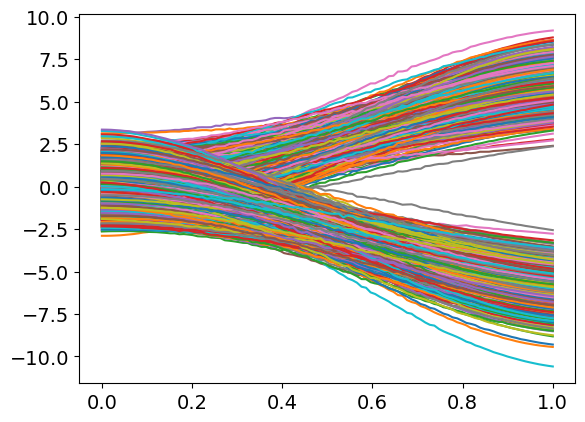

In [36]:
plt.figure()
plt.plot(t_N[:,0,0],X_f[:,:,0])
plt.show()

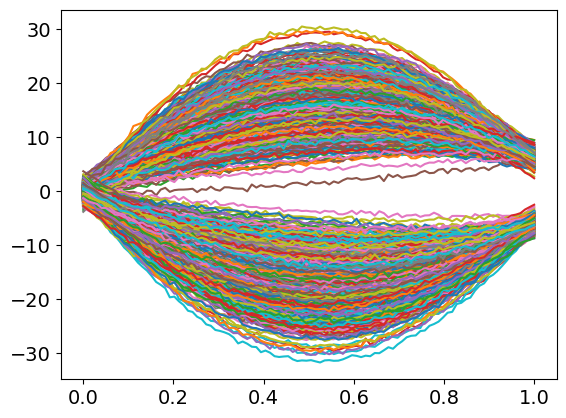

In [37]:
plt.figure()
plt.plot(t_N[:,0,0],X_f[:,:,1])
plt.show()

In [38]:
### learning u = k(x,t)###

ITERS = 30000
BATCH_SIZE = 32
LR = 1e-2

k = score_nn(n,32)
# init_weights(f)
k.train()
optimizer_k = torch.optim.Adam(k.parameters(), lr=LR)

# scheduler_lr = torch.optim.lr_scheduler.StepLR(optimizer_k, step_size=2000, gamma=0.99)
scheduler_lr =  torch.optim.lr_scheduler.ExponentialLR(optimizer_k, gamma=0.999) #set LR = 1e-1

for i in range(ITERS):
    idx = torch.randperm(N)[:BATCH_SIZE]
    X_train = X_f[:,idx,:]
    t_train = t_N[:,idx,:]  
    u_train = u_f[:,idx,:]
    k_value = k.forward(X_train,t_train) 
    loss = nn.MSELoss()(k_value,u_train)
    
    optimizer_k.zero_grad()
    loss.backward()
    optimizer_k.step()

    if i <=2500 or i>= 20000:
        scheduler_lr.step()
    
    if  (i+1)==ITERS or (i+1)%100==0:
        k_value = k.forward(X_f,t_N)
        loss = ((k_value-u_f)*(k_value-u_f)).mean()
        
        print("Iteration: %d/%d, loss = %.12f" %(i+1,ITERS,loss.item()))

Iteration: 100/30000, loss = 302.232025146484
Iteration: 200/30000, loss = 213.259414672852
Iteration: 300/30000, loss = 199.696426391602
Iteration: 400/30000, loss = 196.396942138672
Iteration: 500/30000, loss = 188.337982177734
Iteration: 600/30000, loss = 188.026443481445
Iteration: 700/30000, loss = 186.780715942383
Iteration: 800/30000, loss = 187.693084716797
Iteration: 900/30000, loss = 183.823425292969
Iteration: 1000/30000, loss = 184.322982788086
Iteration: 1100/30000, loss = 182.761001586914
Iteration: 1200/30000, loss = 183.930892944336
Iteration: 1300/30000, loss = 182.917175292969
Iteration: 1400/30000, loss = 181.560104370117
Iteration: 1500/30000, loss = 180.213684082031
Iteration: 1600/30000, loss = 179.678802490234
Iteration: 1700/30000, loss = 179.792922973633
Iteration: 1800/30000, loss = 179.811782836914
Iteration: 1900/30000, loss = 179.404052734375
Iteration: 2000/30000, loss = 176.809494018555
Iteration: 2100/30000, loss = 176.962463378906
Iteration: 2200/30000,

In [39]:
# N = 2000
# T = 1000

t = torch.linspace(0,tf,T).repeat(N).reshape(N,T).T[:,:,None]
dt = tf/T

W_b = torch.zeros((T, N, m))
for i in range(T):
    W_b[i,:,:] = MultivariateNormal(torch.zeros(m), dt*torch.eye(m)).sample((N,))
W_b = torch.cat((torch.zeros((T,N,1)), W_b), dim=2)

X_b = torch.zeros(T,N,n)
X_b[0] = torch.randn(N,n)
#X_b[0] = X[0].clone()
for i in range(0,T-1):
    u_pred = k.forward(X_b[i,None,:,:],t[i,None,:,:])[0]
    
    X_b[i+1] = X_b[i] + (A @ X_b[i].T).T * dt + (B @ u_pred.T).T * dt + n_sigma * W_b[i]

In [40]:
### Learning y = f(x,t) ###

# ITERS = 20000
# BATCH_SIZE = 32
# LR = 1.5e-3

# f = score_nn(n,16)
# # init_weights(f)
# f.train()
# optimizer_f = torch.optim.Adam(f.parameters(), lr=LR)
# scheduler_f = torch.optim.lr_scheduler.StepLR(optimizer_f, step_size=1000, gamma=0.99)

# for i in range(ITERS):
#     idx = torch.randperm(N)[:BATCH_SIZE]
#     X_train = X_f[:,idx,:]
#     t_train = t_N[:,idx,:]  
#     Y_train = y[idx,:]
#     f_value = f.forward(X_train,t_train) 
#     loss = ((f_value-Y_train)*(f_value-Y_train)).mean()
    
#     optimizer_f.zero_grad()
#     loss.backward()
#     optimizer_f.step()
#     scheduler_f.step()
    
#     if  (i+1)==ITERS or (i+1)%100==0:
#         f_value = f.forward(X_f,t_N)
#         loss = ((f_value-y)*(f_value-y)).mean()
        
#         print("Iteration: %d/%d, loss = %.12f" %(i+1,ITERS,loss.item()))

In [41]:
# N = 2000
# T = 1000

# t = torch.linspace(0,tf,T).repeat(N).reshape(N,T).T[:,:,None]
# dt = tf/T

# W_b = torch.zeros((T, N, m))
# for i in range(T):
#     W_b[i,:,:] = MultivariateNormal(torch.zeros(m), dt*torch.eye(m)).sample((N,))
# W_b = torch.cat((torch.zeros((T,N,1)), W_b), dim=2)

# X_b = torch.zeros(T,N,n)
# X_b[0] = torch.randn(N,n)
# #X_b[0] = X[0].clone()
# for i in range(0,T-1):
#     y_pred = f.forward(X_b[i,None,:,:],t[i,None,:,:])[0]
#     # print(torch.inverse(torch.tensor([[(1-t[i,0,0])**3/3, (1-t[i,0,0])**2/2], [(1-t[i,0,0])**2/2, 1-t[i,0,0]]])))
#     u = (torch.tensor([[1 - t[i,0,0],1]]) @ torch.pinverse(torch.tensor([[(1-t[i,0,0])**3/3, (1-t[i,0,0])**2/2], [(1-t[i,0,0])**2/2, 1-t[i,0,0]]])) @ (y_pred - (torch.tensor([[1, 1-t[i,0,0]],[0, 1]]) @ X_b[i].T).T).T).T
#     # print(y_pred)
#     X_b[i+1] = X_b[i] + (A @ X_b[i].T).T * dt + (B @ u.T).T * dt + n_sigma * W_b[i]

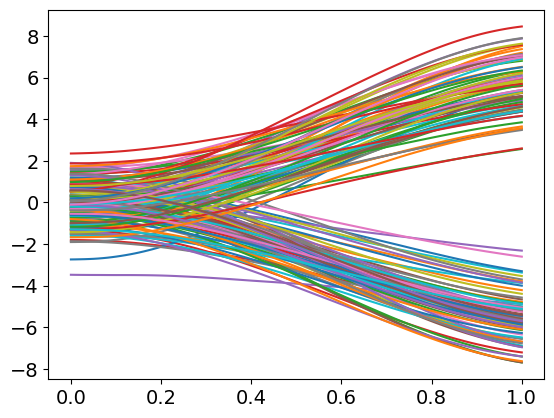

In [42]:
idx = torch.randperm(N)[:150]

for i in idx:
    plt.plot(t[:,i,0],X_b[:,i,0].detach().numpy())

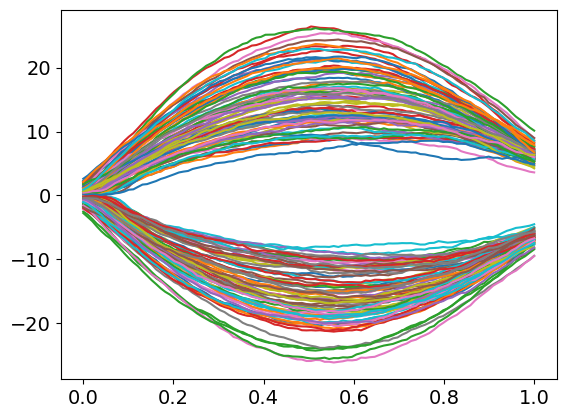

In [43]:
idx = torch.randperm(N)[:150]

for i in idx:
    plt.plot(t[:,i,0],X_b[:,i,1].detach().numpy())

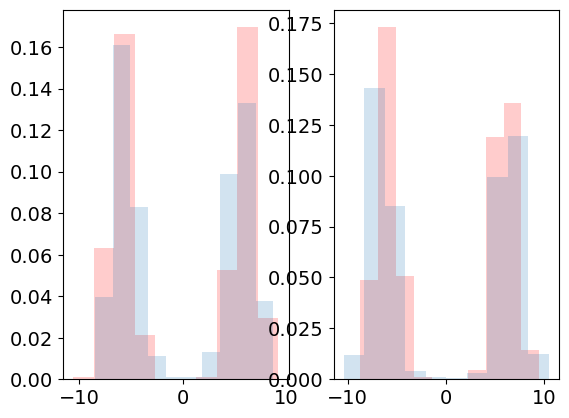

In [44]:
plt.figure()
plt.subplot(1,2,1)
plt.hist(y.numpy()[:,0],alpha=0.2, color='r',density=True)
plt.hist(X_b.detach().numpy()[-1,:,0],alpha=0.2, density=True)
plt.subplot(1,2,2)
plt.hist(y.numpy()[:,1],alpha=0.2, color='r',density=True)
plt.hist(X_b.detach().numpy()[-1,:,1],alpha=0.2, density=True)
plt.show()


In [45]:
print(X_b[-1,:,:].detach().mean(dim = 0))
print(X_b[-1,:,:].detach().std(dim = 0))

tensor([-0.0743, -0.1547])
tensor([5.6990, 6.6079])


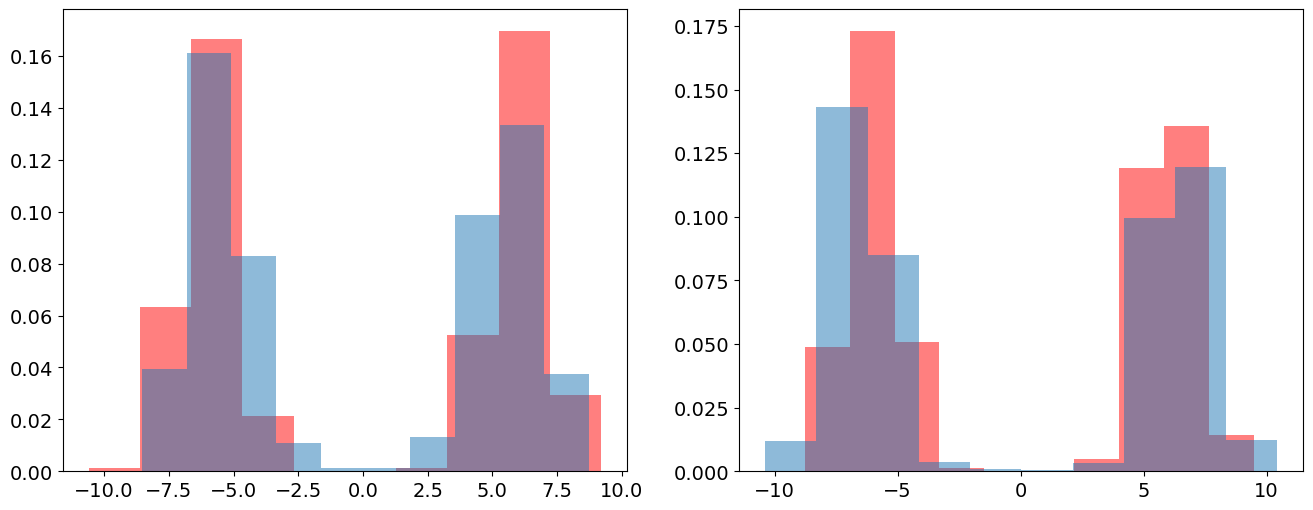

In [46]:
plt.figure(figsize=(16,6 ))
plt.subplot(1,2,1)
plt.hist(X_f.detach().numpy()[-1,:,0],alpha=0.5, color='r',density=True)
plt.hist(X_b.detach().numpy()[-1,:,0],alpha=0.5, density=True)
plt.subplot(1,2,2)
plt.hist(X_f.detach().numpy()[-1,:,1],alpha=0.5, color='r',density=True)
plt.hist(X_b.detach().numpy()[-1,:,1],alpha=0.5, density=True)
plt.show()

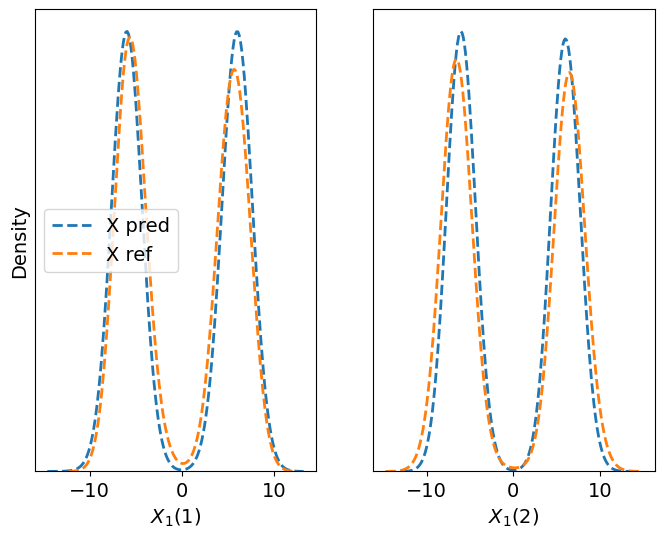

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,6 ))
plt.subplot(1,2,1)
sns.kdeplot(data=X_f.detach().numpy()[-1,:,0],color="C0",lw=2,linestyle='--')
sns.kdeplot(data=X_b.detach().numpy()[-1,:,0],color="C1",lw=2,linestyle='--')
plt.yticks([]) 
plt.plot([],[],label='X pred',color="C0",lw=2,linestyle='--')
plt.plot([],label='X ref',color="C1",lw=2,linestyle='--')
plt.xlabel(r'$X_1(1)$')
plt.legend()

plt.subplot(1,2,2)
sns.kdeplot(data=X_f.detach().numpy()[-1,:,1],label='X_1(1)',color="C0",lw=2,linestyle='--')
sns.kdeplot(data=X_b.detach().numpy()[-1,:,1],label='X_1(1)',color="C1",lw=2,linestyle='--')

ax = plt.gca()
plt.yticks([]) 
ax.get_yaxis().set_visible(False)
plt.xlabel(r'$X_1(2)$')

plt.savefig('noisy_oscillator_final_time_density.pdf')


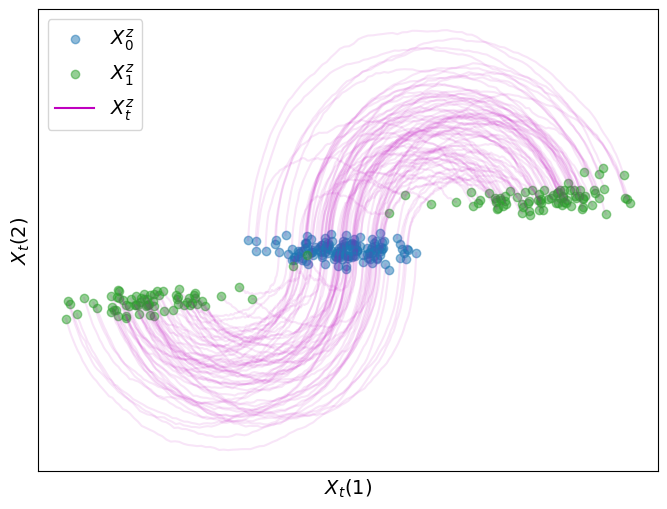

In [ ]:
idx = torch.randperm(N)[:150]
plt.figure(figsize=(8,6 ))
for i in idx: 
    plt.plot(X_b[:,i,0].detach().numpy(),X_b[:,i,1].detach().numpy(),color='m',alpha=0.1)

# plt.scatter(y[idx,0].detach().numpy(),y[idx,1].detach().numpy(),marker='x',color='C8',label= 'y',alpha=0.9)

plt.scatter(X_b[0,idx,0].detach().numpy(),X_b[0,idx,1].detach().numpy(),color='C0',label= r'$X_0^z$',alpha=0.5)
plt.scatter(X_b[-1,idx,0].detach().numpy(),X_b[-1,idx,1].detach().numpy(),color='C2',label= r'$X_1^z$',alpha=0.5)
plt.plot([],[],color='m',label=r'$X_t^z$')

# for i in idx: 
#     plt.plot(X_f[:,i,0].detach().numpy(),X_f[:,i,1].detach().numpy(),color='C5',alpha=0.2)

# plt.scatter(X_f[0,idx,0].detach().numpy(),X_f[0,idx,1].detach().numpy(),color='C1',label= 'initial particles xf',alpha=0.5,marker='x')
# plt.scatter(X_f[-1,idx,0].detach().numpy(),X_f[-1,idx,1].detach().numpy(),color='C3',label= 'target particles xf',alpha=0.5,marker='x')


# plt.plot([],[],color='m',label='trajectory')

plt.xticks([])  # Remove x-axis tick labels
plt.yticks([])  # Remove y-axis tick labels

plt.legend()
plt.xlabel(r'$X_t(1)$')
plt.ylabel(r'$X_t(2)$')

plt.savefig('noisy_oscillator_state_traj.pdf')


In [49]:
import ot
w2_dist = []
for i in range(T):
    print(i)
    # Compute the cost matrix (usually the Euclidean distance matrix)
    dist =  ot.dist(X_b[i,].detach().numpy(), X_f[i,].detach().numpy()) 

    # Uniform weights if distributions are unweighted
    a = np.ones(N) / N # Uniform weights for X
    b = np.ones(N) / N # Uniform weights for Y

    # Compute the Wasserstein distance (emd2 returns the squared distance)
    w2_dist.append(np.sqrt(ot.emd2(a, b, dist)))
   
dist_xb =  ot.dist(X_b[-1,].detach().numpy(), y.detach().numpy()) 
dist_xf =  ot.dist(X_f[-1,].detach().numpy(), y.detach().numpy()) 
# Uniform weights if distributions are unweighted
a = np.ones(N) / N # Uniform weights for X
b = np.ones(N) / N # Uniform weights for Y

# Compute the Wasserstein distance (emd2 returns the squared distance)
w2_dist_xb= np.sqrt(ot.emd2(a, b, dist_xb))
w2_dist_xf= np.sqrt(ot.emd2(a, b, dist_xf))

print('w_2 X_b:',w2_dist_xb)
print('w_2 X_f:',w2_dist_xf)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
w_2 X_b: 1.251624328762443
w_2 X_f: 0.0013253935607284025


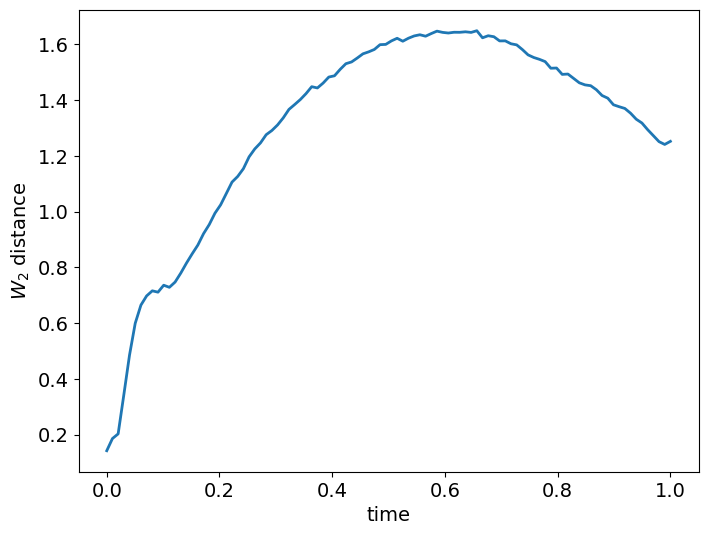

In [50]:
plt.figure(figsize=(8,6 ))
plt.plot(t[:,0,0],w2_dist,lw=2)
plt.xlabel(r'time')
plt.ylabel(r'$W_2$ distance')

plt.savefig('noisy_oscillator_w2_distance.pdf')